In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rand
import scipy.optimize
from scipy import stats

In [2]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 400

In [3]:
EXPECTED_AREA = 1.506484

In [18]:
def mandelbrot(xmin, xmax, ymin, ymax, xiter, yiter, limit):
    """ 
    Creates a list of pixel values that can be used to plot the mandelbrot set
    """
    a_step = 0

    pixel_list = np.ndarray((xiter + 2, yiter + 2))

    for a in np.linspace(xmin, xmax, xiter):
        a_step += 1
        b_step = 0
        for b in np.linspace(ymin, ymax, yiter):
            b_step += 1
            z_0 = complex(a, b)
            z = z_0
            counter = 0

            while abs(z) < 2 and counter < limit:
                z = z ** 2 + z_0
                counter += 1
                
            pixel_list[b_step][a_step] = counter
    

    return pixel_list

xmin = -2
xmax = 0.5
ymin = -2
ymax = 2
xiter = 2000
yiter = 2000
limit = 250

pixel_list = mandelbrot(xmin, xmax, ymin, ymax, xiter, yiter, limit)


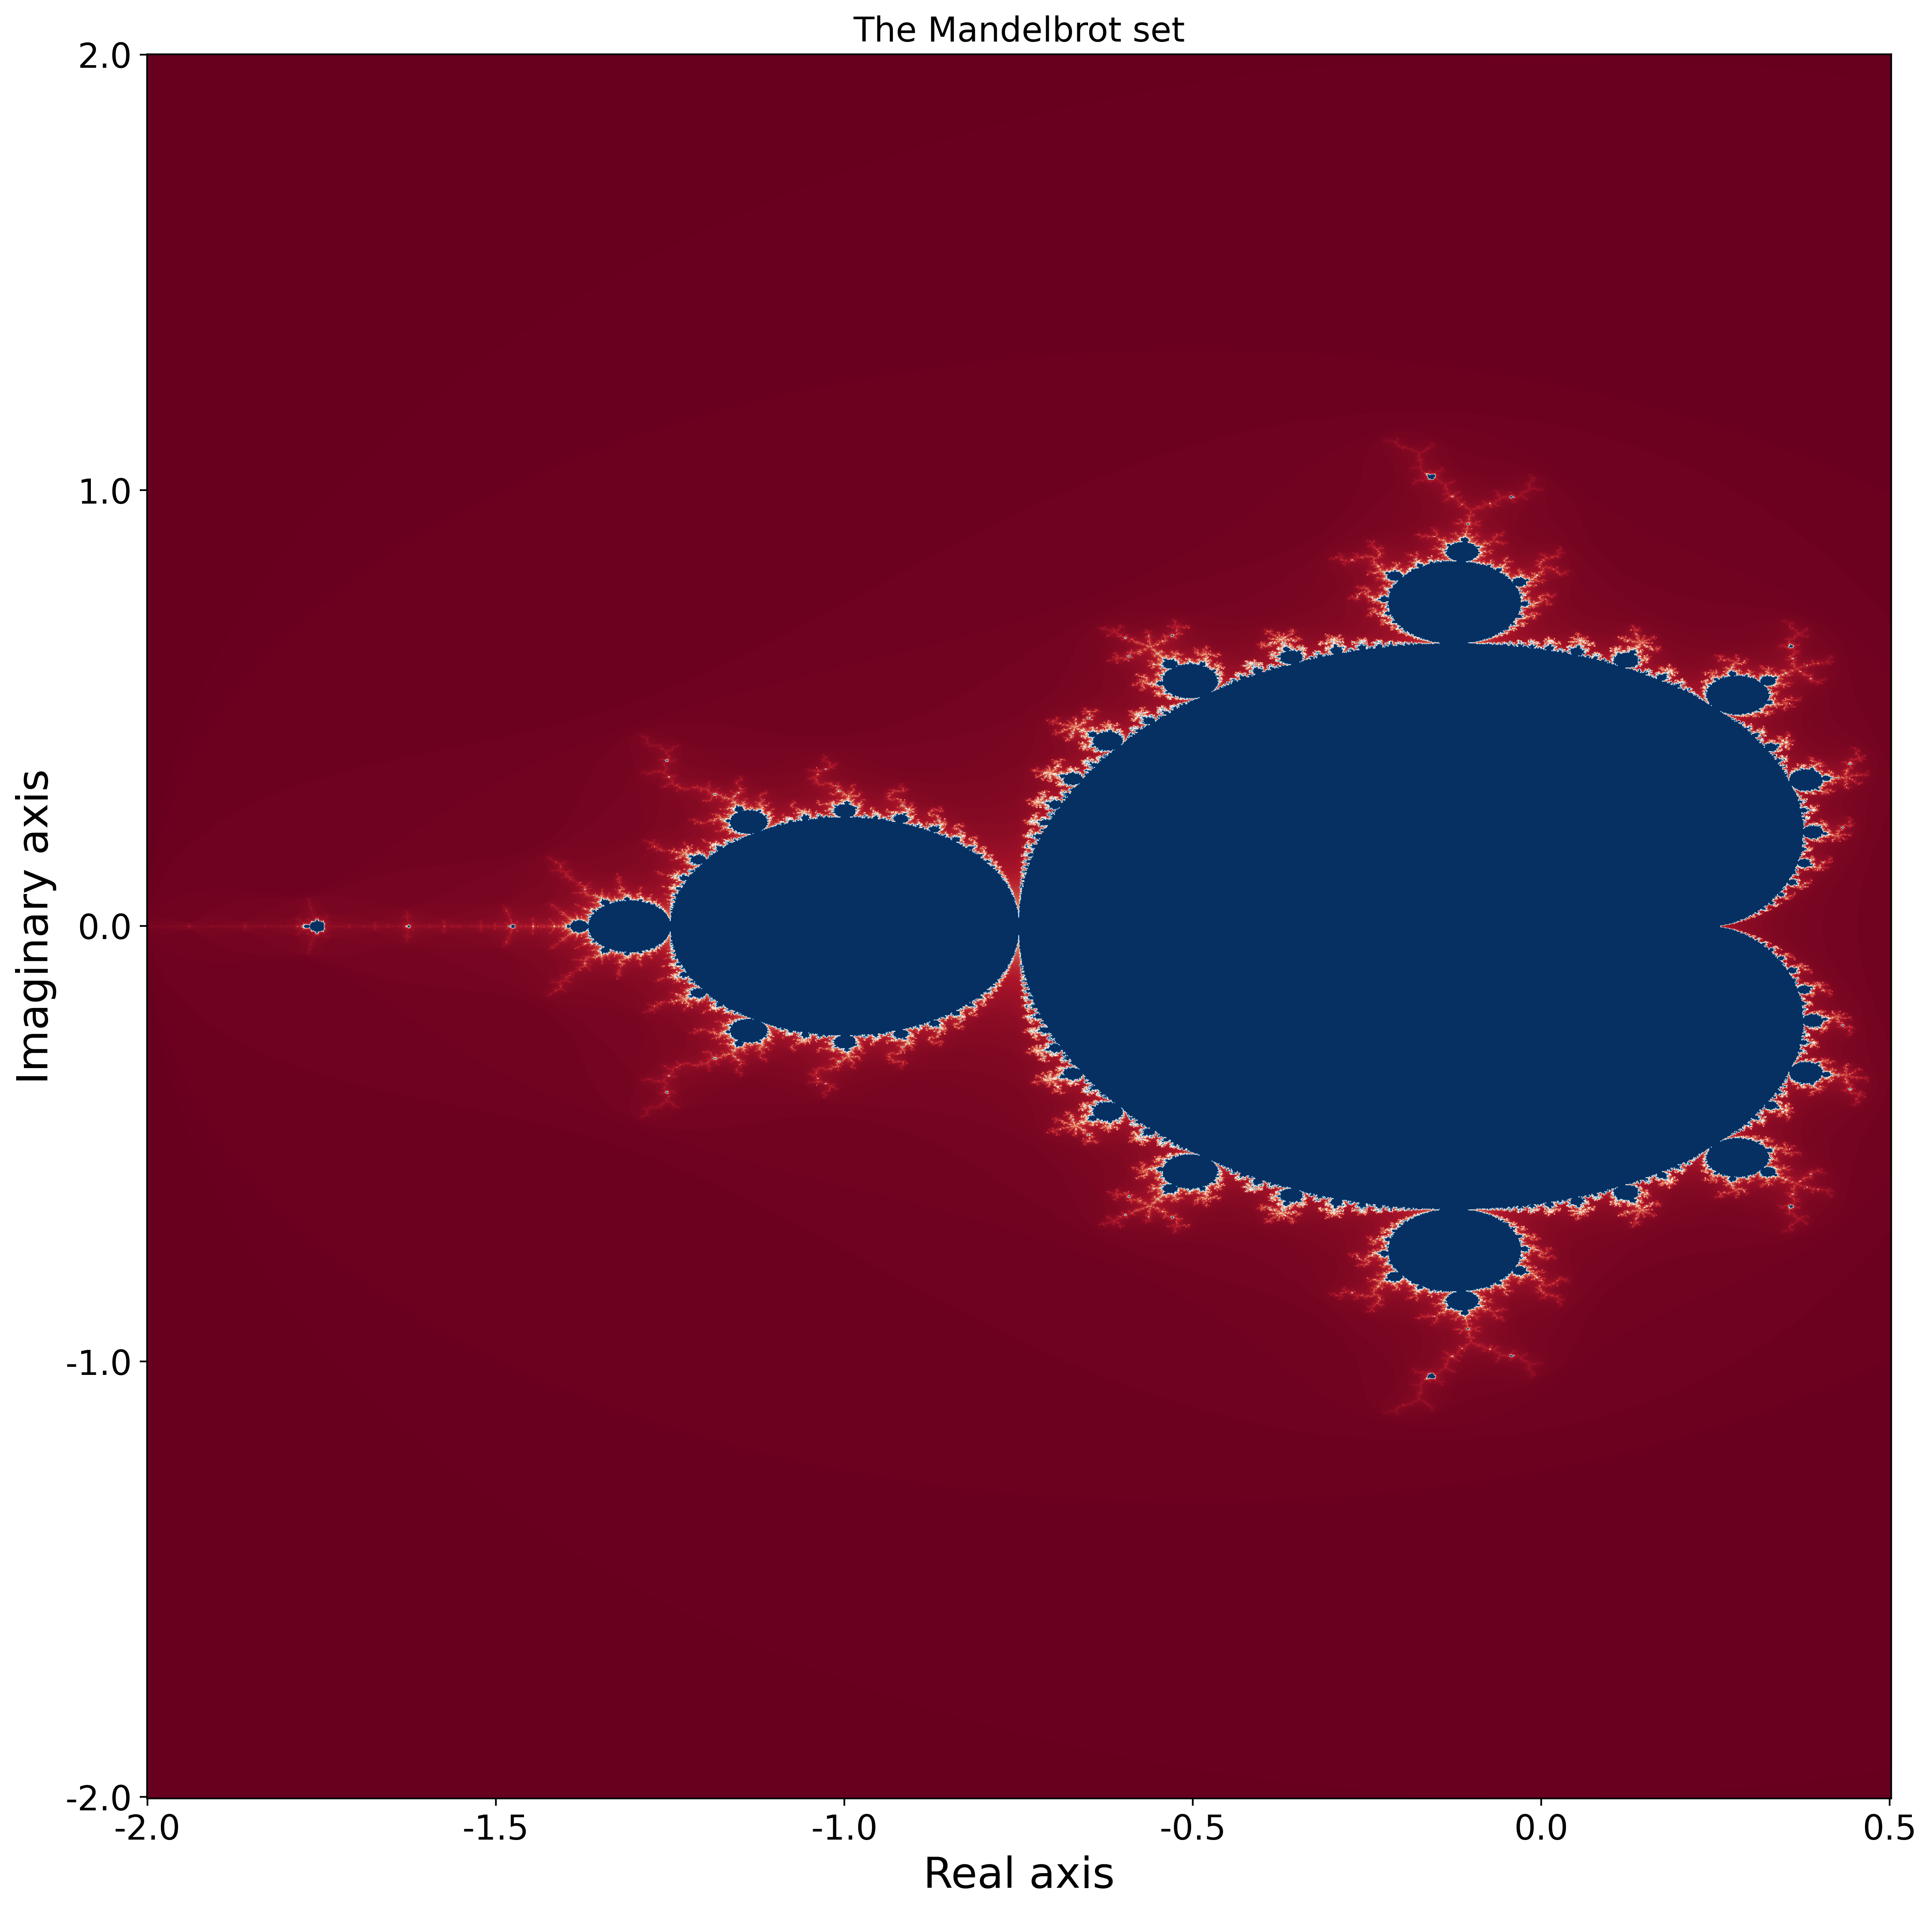

In [19]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize = (15, 15))
plt.imshow(pixel_list, cmap='RdBu')
plt.title("The Mandelbrot set")
plt.xticks(ticks=range(0, 2001, 400), labels=np.linspace(-2, 0.5, 6))
plt.yticks(ticks=range(0, 2001, 500), labels=np.linspace(2, -2, 5))
plt.xlabel("Real axis")
plt.ylabel("Imaginary axis")
plt.show()


In [20]:
xmin = -2
xmax = 0.5
ymin = -2
ymax = 2
xiter = 2000
yiter = 2000
limit = 250

pixel_list = mandelbrot(xmin, xmax, ymin, ymax, xiter, yiter, limit)


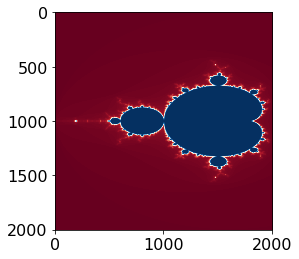

In [21]:
%matplotlib inline
plt.imshow(pixel_list, cmap='RdBu')
plt.show()


In [4]:
def determine_area(i = 25, s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2, sample_method="pure"):
    """
    Determine the area of the mandelbrot set.

    Parameters:
    i: int, Max number of iterations
    s: int, The number of sample points.
    sample_method: string, options are:
        'pure': pure random sampling,
        'hypercube': hypercube sampling,
        'orthogonal': orthogonal sampling
    """
    
    bounding_box_area = (xmax - xmin) * (ymax - ymin)

    Z = generate_sample_points(sample_method, s=s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

    Z0 = Z

    N = np.zeros(Z.shape)

    for _ in range(i):
        Z = np.where(abs(Z) < 2, Z ** 2 + Z0, 100)

    N[Z != 100] = 1

    n_good_points = sum(N)
    
    return bounding_box_area * (n_good_points / s)

def generate_sample_points(sample_method, s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    
    if sample_method == "pure":
        return generate_sample_points_pure_random(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    elif sample_method == "hypercube":
        return generate_sample_points_hypercube(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    elif sample_method == "orthogonal":
        return generate_sample_points_orthogonal(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
    else:
        print("ERROR: invalid sample_method")

def generate_sample_points_pure_random(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    
    X = rand.rand(s) * (xmax - xmin) + xmin
    Y = rand.rand(s) * (ymax - ymin) + ymin

    return X + Y * 1j

def generate_sample_points_hypercube(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    sampler = stats.qmc.LatinHypercube(2)
    points = sampler.random(s)

    l_bounds = [xmin, ymin]
    u_bounds = [xmax, ymax]

    points = stats.qmc.scale(points, l_bounds, u_bounds)

    return points[:,0] + points[:,1] * 1j

def generate_sample_points_orthogonal(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    
    # Calculate the number of major cells. This has to be an integer
    n_major_cells = int(np.sqrt(s))
    n_samples = n_major_cells * n_major_cells

    shape = (n_major_cells, n_major_cells)
    xlist = np.zeros(shape)
    ylist = np.zeros(shape)
    
    m = 0
    for i in range(n_major_cells):
        for j in range(n_major_cells):

            xlist[i][j] = m
            ylist[i][j] = m

            m += 1

    # Shuffle each row of the x and y lists
    for i in range(n_major_cells):
        np.random.shuffle(xlist[i])
        np.random.shuffle(ylist[i]) 
    
    # Transpose y since the ylist should have major rows instead of major columns
    ylist = np.transpose(ylist)
    
    # Create a 1D array from the 2D array
    xlist = np.ndarray.flatten(xlist)
    ylist = np.ndarray.flatten(ylist)

    # Calculate the width and height of each column and row
    xscale = (xmax - xmin) / n_samples
    yscale = (ymax - ymin) / n_samples

    # Calculate the points within the minor rows and columns
    X = xmin + xscale * (xlist + rand.rand(n_samples))
    Y = ymin + yscale * (ylist + rand.rand(n_samples))

    return X + Y * 1j


## Error estimation

In [5]:
def calc_error(i, s):

    return determine_area(i=i, s=s) - EXPECTED_AREA

In [ ]:
# Calc i errors
for i in [1, 10, 100, 1000, 10000, 10000]:
    print(f"{i}: {calc_error(i, 1000000):e}")


In [ ]:
# Calc s errors
for s in [1, 10, 100, 1000, 10000, 100000]:

    # At low s values the error will have a high variance, therefore we sample 
    # the error multiple times. There is also a error in the i value, which is 
    # substracted from the calculated error.
    errors = []
    for _ in range(100):
        errors.append(abs(calc_error(1000, s)) - 0.0042440000000001366)

    print(f"{s}: {sum(errors) / len(errors):e}")

### i error

|i     |error                |
|------|---------------------|
|1     |8.598812000000002e0  |
|10    |5.164399999999998e-1 |
|100   |3.481999999999963e-2 |
|1000  |4.2440000000001366e-3|
|10000 |5.24000000000191e-4  |

These errors were computed with s=1000000. It is assumed that these are enough samples that the error over s is negligible

### s error

|s     |error       |
|------|------------|
|1     |2.400943e+0 |
|10    |1.011442e+0 |
|100   |2.949779e-1 |
|1000  |1.028386e-1 |
|10000 |2.946552e-2 |
|100000|6.576960e-3 |

These errors were computed with i=1000. The error over i has been substracted from these results.

a: -1.0515458827772826 +- 0.044311193554929226, c: 6.462053009439011 +- 0.8655177164705702


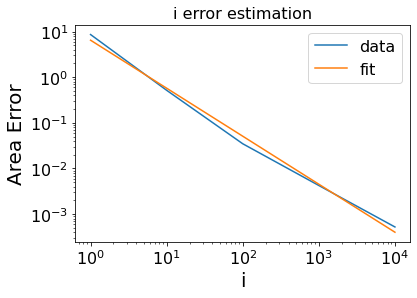

a: -0.5107513483256161 +- 0.019836593660869373, c: 2.9465444746042597 +- 0.3770710930735907


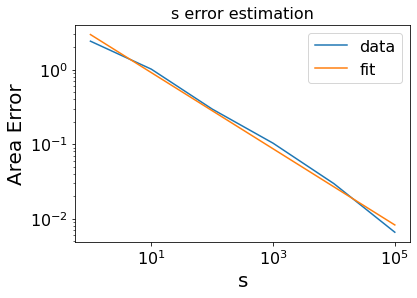

In [22]:
i_values = [1, 10, 100, 1000, 10000]
i_errors = [8.598812000000002e0, 5.164399999999998e-1, 3.481999999999963e-2, 4.2440000000001366e-3, 5.24000000000191e-4]

s_values = [1, 10, 100, 1000, 10000, 100000]
s_errors = [2.400943e+0, 1.011442e+0, 2.949779e-1, 1.028386e-1, 2.946552e-2, 6.576960e-3]

def linear_function(x, a=1, b=1):
    return a * x + b
    
def exponential_function(x, a=1, c=1):
    return c * x ** a

def inverse_exponential_function(y, a=1, c=1):
    """
    Returns the inverse of the exponential function: y = cx^a.
    """

    return (y / c) ** (1/a)

def calc_error_fit(values, errors):
    """
    This function finds the fit parameters a and c for the function y = cx ^ a. 
    It does this by first taking a linear fit against the logarithmic x and y data. 
    This linear fit is then converted to the logarithmic function.

    https://stackoverflow.com/a/30672483
    """

    popt, pcov = scipy.optimize.curve_fit(linear_function, np.log10(values), np.log10(errors), p0=[1, -1])
    perr = np.sqrt(np.diag(pcov))
    
    a, b = popt[0], popt[1]
    c = 10 ** b

    rel_error = perr[1] / b

    print(f"a: {a} +- {perr[0]}, c: {c} +- {c * rel_error}")

    return a, c


def plot_error(values, errors, title="", xlabel=""):
    
    a, c = calc_error_fit(values, errors)

    # Compute the fitted values back to expected values
    y_fit_values = [exponential_function(value, a=a, c=c) for value in values]
    
    plt.plot(values, errors, label="data")
    plt.plot(values, y_fit_values, label="fit")

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel(xlabel)
    plt.ylabel("Area Error")

    plt.title(title)
    plt.legend()
    plt.show()

plot_error(i_values, i_errors, title="i error estimation", xlabel="i")
plot_error(s_values, s_errors, title="s error estimation", xlabel="s")

## Excercise 2

In [23]:
def plot_j_dependance(i = 25, sample_method="pure"):

    s = get_s_with_comparable_error(i)
    
    area_differences = []
    js = []
    for j in range(1, i):
        js.append(j)
        area_differences.append(determine_area(i=j, s=s, sample_method=sample_method) - EXPECTED_AREA)

    plt.plot(js, area_differences)
    plt.ylabel("Area difference")
    plt.xlabel("j")
    plt.show()

def get_s_with_comparable_error(i):
    """
    Gets a s value, which has comparable error as the error in i.
    """

    # Obtain the fit parameters from the error data in i and s
    i_fit_values = calc_error_fit(i_values, i_errors)
    s_fit_values = calc_error_fit(s_values, s_errors)

    # Get the estimated i error
    i_error = exponential_function(i, a=i_fit_values[0], c=i_fit_values[1])

    # Calculate s from i error
    s = inverse_exponential_function(i_error, a=s_fit_values[0], c=s_fit_values[1])
    print("s", s)

    return int(s)


a: -1.0515458827772826 +- 0.044311193554929226, c: 6.462053009439011 +- 0.8655177164705702
a: -0.5107513483256161 +- 0.019836593660869373, c: 2.9465444746042597 +- 0.3770710930735907
s 2817.6473312698895


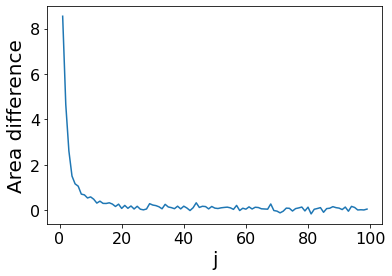

In [24]:
plot_j_dependance(i=100)

## Quad tree sampling

In [25]:
class Box():

    def __init__(self, xmin, xmax, ymin, ymax):

        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax

    def calc_area(self):

        return (self.xmax - self.xmin) * (self.ymax - self.ymin)

    def __str__(self):

        return f"{self.xmin}, {self.xmax}, {self.ymin}, {self.ymax}"

def subdivide_box(box):

    xcenter = (box.xmax + box.xmin) / 2
    ycenter = (box.ymax + box.ymin) / 2

    box1 = Box(box.xmin, xcenter, box.ymin, ycenter)
    box2 = Box(xcenter, box.xmax, box.ymin, ycenter)
    box3 = Box(box.xmin, xcenter, ycenter, box.ymax)
    box4 = Box(xcenter, box.xmax, ycenter, box.ymax)

    return (box1, box2, box3, box4)

def quad_tree_area(box, box_area_treshold=0.001, s=100, i=1000, sample_method="pure"):
    """
    Returns:
    area: The mandelbrot area inside the box.
    evals: The number of box evaulations performed to obtain this area.
    """

    if box.calc_area() < box_area_treshold:
        return determine_area(s=s, i=i, xmin=box.xmin, xmax=box.xmax, ymin=box.ymin, ymax=box.ymax, sample_method=sample_method), 1

    Z0 = generate_sample_points(sample_method, s=s, xmin=box.xmin, xmax=box.xmax, ymin=box.ymin, ymax=box.ymax)

    Z = Z0

    for _ in range(i):

        Z = np.where(abs(Z) < 2, Z ** 2 + Z0, 100)
        
        # If all points diverge return 0
        if (np.abs(Z) > 2).all():
            return 0, 1

    # if all points points still havent diverged return area of box
    if(np.abs(Z) <  2).all():
        return box.calc_area(), 1

    # At this point in the code the box contains both converge and diverge points.
    # The box is subdived box in 4 smaller boxs from which the area is calculated.

    boxs = subdivide_box(box)
    area = 0
    evals = 0
    for b in boxs:
        results = quad_tree_area(b, box_area_treshold=box_area_treshold, s=s, i=i)
        area += results[0]
        evals += results[1]

    return area, evals


In [26]:
quad_tree_area(Box(-2, 1, -2, 2))

(1.49401611328125, 937)

## Sampling method comparisons

In [30]:
def get_boxplot_data(s=10000, i=1000, nruns=10):

    data_entries = [[] for _ in range(6)]

    box = Box(-2, 1, -2, 2)

    for _ in range(nruns):
        print(_)
        
        data_entries[0].append(determine_area(s=s, i=i, sample_method="pure"))
        data_entries[1].append(determine_area(s=s, i=i, sample_method="hypercube"))
        data_entries[2].append(determine_area(s=s, i=i, sample_method="orthogonal"))

        data_entries[3].append(quad_tree_area(box, s=122, i=i, sample_method="pure")[0])
        data_entries[4].append(quad_tree_area(box, s=122, i=i, sample_method="hypercube")[0])
        data_entries[5].append(quad_tree_area(box, s=122, i=i, sample_method="orthogonal")[0])

    return data_entries

def plot_sampling_comparison(data_entries, labels):

    plt.boxplot(data_entries, labels=labels)
    plt.axhline(EXPECTED_AREA, linestyle="--")
    plt.xticks(rotation=45)

    plt.ylabel("Area")
    plt.tight_layout()
    plt.title("Algorithm comparisons")
    plt.show()

def print_p_values(data_entries, labels):
    """
    Gets a pvalue for each data-entry against the others and prints these results.
    """

    print("Label 1 | Label 2 | p-value")
    for i in range(len(data_entries)):
        for j in range(i):

            data1 = data_entries[i]
            data2 = data_entries[j]

            pvalue = get_pvalue(data1, data2)

            print(f"{labels[i]} vs {labels[j]}: {pvalue:.3e}")

def print_mean_and_variance(data_entries, labels):

    print("Label | Mean | Std")
    for i in range(len(data_entries)):
        print(f"{labels[i]}, {np.mean(data_entries[i]):.3e}, {np.std(data_entries[i]):.3e}")

def get_pvalue(data1, data2):
    """Calculates the pvalue for two data sets. """

    return stats.ttest_ind(data1, data2).pvalue


In [29]:
data_entries = get_boxplot_data(s=100000, i=1000, nruns=25)
labels = ["pure", "hypercube", "orthogonal", "quad pure", "quad hypercube", "quad orthogonal"]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


Label 1 | Label 2 | p-value
hypercube vs pure: 5.893e-01
orthogonal vs pure: 6.554e-01
orthogonal vs hypercube: 8.759e-02
quad pure vs pure: 1.620e-02
quad pure vs hypercube: 3.380e-05
quad pure vs orthogonal: 9.937e-07
quad hypercube vs pure: 3.116e-02
quad hypercube vs hypercube: 8.787e-05
quad hypercube vs orthogonal: 1.237e-06
quad hypercube vs quad pure: 5.041e-01
quad orthogonal vs pure: 4.723e-02
quad orthogonal vs hypercube: 2.915e-04
quad orthogonal vs orthogonal: 5.758e-05
quad orthogonal vs quad pure: 3.613e-01
quad orthogonal vs quad hypercube: 7.515e-01
Label | Mean | Std
pure, 1.509e+00, 1.301e-02
hypercube, 1.511e+00, 8.000e-03
orthogonal, 1.508e+00, 1.454e-03
quad pure, 1.502e+00, 4.925e-03
quad hypercube, 1.503e+00, 4.164e-03
quad orthogonal, 1.504e+00, 4.866e-03


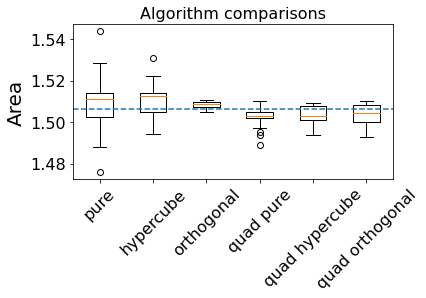

In [31]:
print_p_values(data_entries, labels)
print_mean_and_variance(data_entries, labels)
plot_sampling_comparison(data_entries, labels)